### Data Preparation & Advanced EDA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

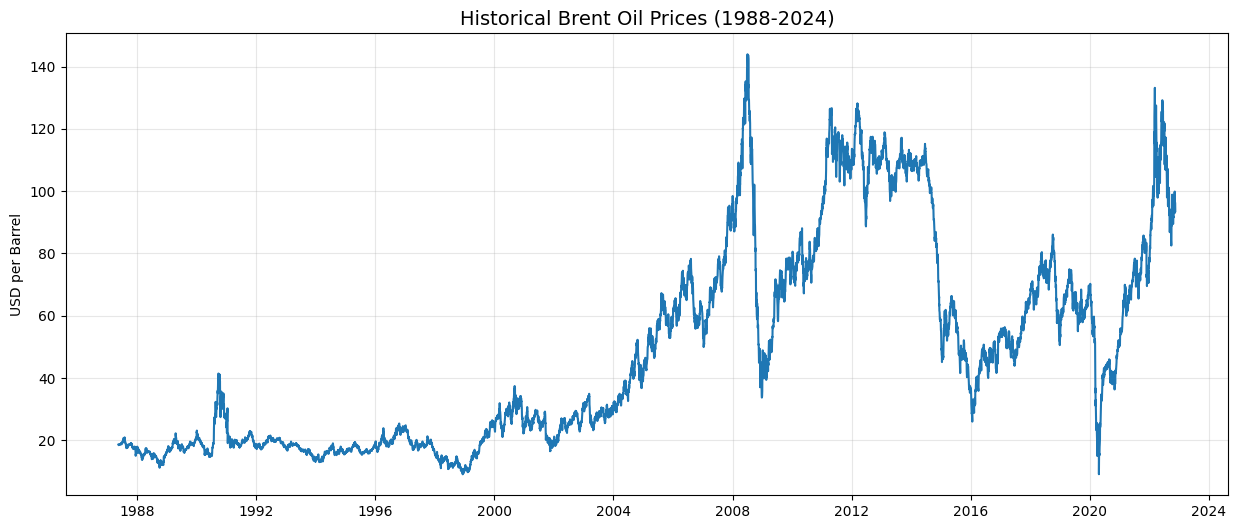

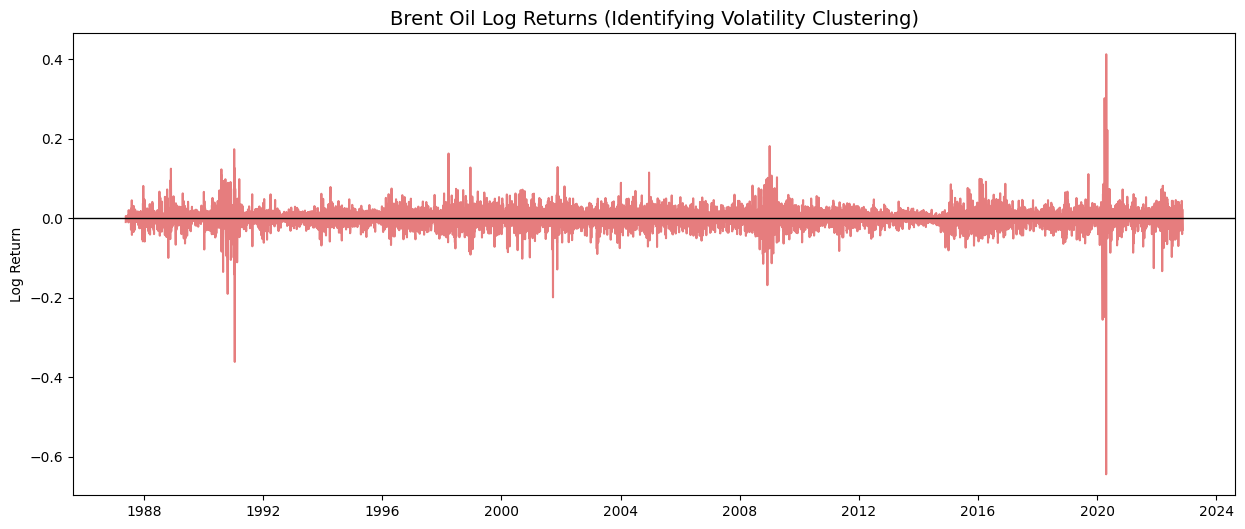

In [6]:
df = pd.read_csv('../Data/brent_prices_with_events.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Plot Raw Price Series
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Price'], label='Brent Crude Price', color='#1f77b4')
plt.title('Historical Brent Oil Prices (1988-2024)', fontsize=14)
plt.ylabel('USD per Barrel')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate Log Returns for stationarity
# Formula: log(p_t) - log(p_t-1)
df['Log_Returns'] = np.log(df['Price']) - np.log(df['Price'].shift(1))

# Plot Log Returns to observe Volatility Clustering
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Log_Returns'], color='#d62728', alpha=0.6)
plt.axhline(0, color='black', lw=1)
plt.title('Brent Oil Log Returns (Identifying Volatility Clustering)', fontsize=14)
plt.ylabel('Log Return')
plt.show()

### Build the Bayesian Change Point Model

In [12]:
import sys
import scipy.signal

# Manually patch the missing 'gaussian' function into scipy.signal
# This tricks ArviZ into thinking everything is fine
if not hasattr(scipy.signal, 'gaussian'):
    from scipy.signal import windows
    scipy.signal.gaussian = windows.gaussian
    print("Patch applied: scipy.signal.gaussian is now linked.")
else:
    print("scipy.signal.gaussian already exists.")

# Now try the imports
import pymc as pm
import numpy as np
import arviz as az
print("Imports successful!")

scipy.signal.gaussian already exists.
Imports successful!


In [16]:
# Prepare data
prices = df['Price'].values
idx = np.arange(len(prices))
mean_price = prices.mean()

with pm.Model() as oil_model:
    # Priors
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(prices) - 1)
    mu_1 = pm.Exponential("mu_1", 1.0 / mean_price)
    mu_2 = pm.Exponential("mu_2", 1.0 / mean_price)
    sigma = pm.HalfNormal("sigma", sigma=prices.std())
    
    # Logic
    mu_ = pm.math.switch(tau > idx, mu_1, mu_2)
    
    # Likelihood
    obs = pm.Normal("obs", mu=mu_, sigma=sigma, observed=prices)
    
    # Sampling - Using cores=4 (or more) to parallelize
    # If you have 'numpyro' installed, you can add nuts_sampler="numpyro"
    trace = pm.sample(2000, tune=1000, chains=4, cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


### Check Convergence and Visualize

          mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_1    21.426  0.275    20.911    21.934      0.003    0.002   11856.0   
mu_2    75.604  0.277    75.081    76.124      0.003    0.002   10995.0   
tau   4520.973  3.345  4515.000  4527.000      0.084    0.059    1618.0   

      ess_tail  r_hat  
mu_1    6792.0    1.0  
mu_2    5904.0    1.0  
tau     1758.0    1.0  


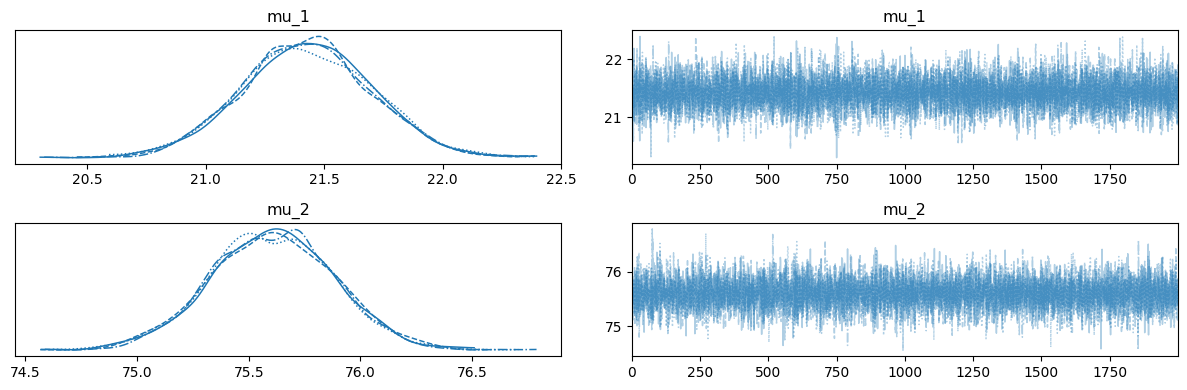

<Figure size 1000x500 with 0 Axes>

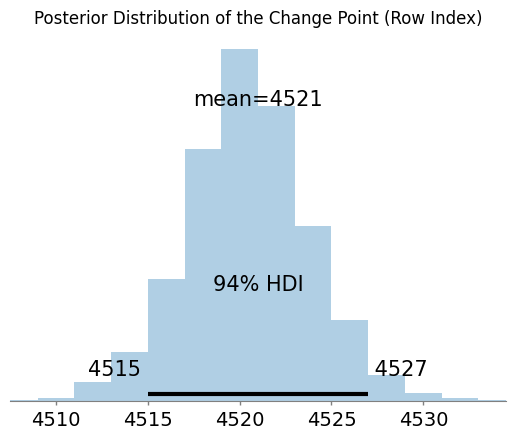

In [17]:
# Check for Convergence (Look for r_hat ≈ 1.0)
summary = az.summary(trace, var_names=["mu_1", "mu_2", "tau"])
print(summary)

# Trace Plots (Confirming the chains explored the same area)
az.plot_trace(trace, var_names=["mu_1", "mu_2"])
plt.tight_layout()
plt.show()

# Identify the Change Point (Posterior of tau)
plt.figure(figsize=(10, 5))
az.plot_posterior(trace, var_names=["tau"], round_to=0)
plt.title("Posterior Distribution of the Change Point (Row Index)")
plt.show()

### Map the Index to a Date

In [18]:
# Get the mean value of tau from the trace
tau_mean = int(trace.posterior['tau'].mean())
detected_date = df.iloc[tau_mean]['Date']
detected_event = df.iloc[tau_mean]['Event_Name']

print(f"--- Model Results ---")
print(f"The model detected a structural break at index: {tau_mean}")
print(f"Calendar Date: {detected_date.strftime('%Y-%m-%d')}")
print(f"Closest Researched Event: {detected_event}")

--- Model Results ---
The model detected a structural break at index: 4520
Calendar Date: 2005-02-23
Closest Researched Event: No Event


### Quantifying the Impact

In [19]:
mu1_val = summary.loc['mu_1', 'mean']
mu2_val = summary.loc['mu_2', 'mean']
percent_change = ((mu2_val - mu1_val) / mu1_val) * 100

print(f"--- Quantified Impact ---")
print(f"Pre-change mean: ${mu1_val:.2f}")
print(f"Post-change mean: ${mu2_val:.2f}")
print(f"Absolute Increase: ${mu2_val - mu1_val:.2f}")
print(f"Percentage Shift: {percent_change:.2f}%")

--- Quantified Impact ---
Pre-change mean: $21.43
Post-change mean: $75.60
Absolute Increase: $54.18
Percentage Shift: 252.86%


### Final Visualization

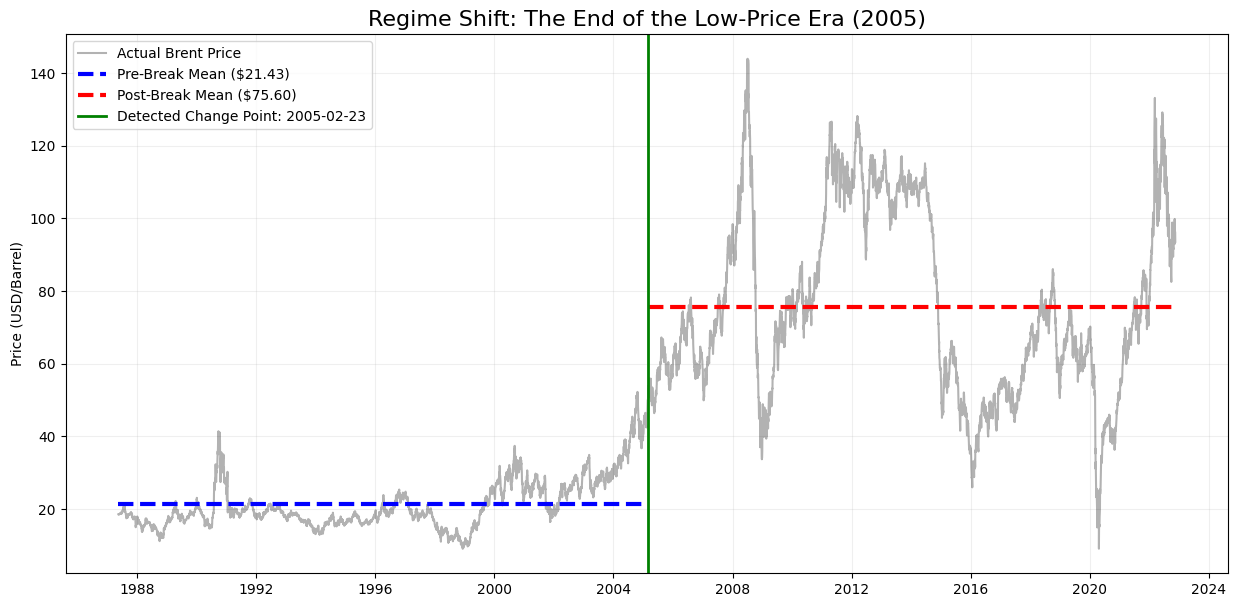

In [20]:
plt.figure(figsize=(15, 7))

# Plot the actual prices
plt.plot(df['Date'], df['Price'], label='Actual Brent Price', color='black', alpha=0.3)

# Plot the "Before" Mean
plt.hlines(mu1_val, xmin=df['Date'].min(), xmax=detected_date, 
           color='blue', linestyles='--', lw=3, label=f'Pre-Break Mean (${mu1_val:.2f})')

# Plot the "After" Mean
plt.hlines(mu2_val, xmin=detected_date, xmax=df['Date'].max(), 
           color='red', linestyles='--', lw=3, label=f'Post-Break Mean (${mu2_val:.2f})')

# Mark the Change Point
plt.axvline(detected_date, color='green', lw=2, label=f'Detected Change Point: {detected_date.date()}')

plt.title('Regime Shift: The End of the Low-Price Era (2005)', fontsize=16)
plt.ylabel('Price (USD/Barrel)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()